# Compose: Training a model to generate music

In [1]:
import os
import pickle
import numpy
import pydot
from music21 import note, chord

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

from models.RNNAttention import get_distinct, create_lookups, prepare_sequences, get_music_list, create_network

Using TensorFlow backend.


## Set parameters

In [17]:
# run params
section = 'compose'
run_id = '0006'
genre_name = 'jazz'
composer_name='ChetBaker'

run_folder = 'run/{}/{}/'.format(section, genre_name)
run_folder += '_'.join([run_id, composer_name])


store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join('data', genre_name, composer_name)

if not os.path.exists(run_folder):
    os.mkdir(run_folder)
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))
    


mode = 'build' # 'load' # 

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 100
rnn_units = 256
use_attention = True

## Extract the notes

In [18]:
data_folder

'data/classical/strauss'

In [19]:
if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
        

        for interval in intervals:

            score = original_score.transpose(interval)

            notes.extend(['START'] * seq_len)
            durations.extend([0]* seq_len)

            for element in score.flat:
                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f)
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f) 

4 files in total
1 Parsing data/classical/strauss/76.mid
2 Parsing data/classical/strauss/1816dandt.mid
3 Parsing data/classical/strauss/1774dtrans.mid
4 Parsing data/classical/strauss/494quixote.mid


## Create the lookup tables

In [20]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
#velocity_names, n_velocities = get_distinct(velocities)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
#velocity_to_int, int_to_velocity = create_lookups(velocity_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [21]:
print('\nnote_to_int')
note_to_int


note_to_int


{'A1': 0,
 'A1.A2': 1,
 'A1.A2.A3': 2,
 'A1.A2.A3.A4.A5': 3,
 'A1.A2.A3.A4.G5.A5': 4,
 'A1.A2.A3.B3.D4.A4.B4.D5.A5': 5,
 'A1.A2.A3.B3.D4.A4.B4.D5.G5.A5': 6,
 'A1.A2.A3.B3.D4.E4.F#4.G4.B4.D5.F#5.B5.D6.F#6': 7,
 'A1.A2.A3.C#4.F#4.A4.C#5.F#5.A5': 8,
 'A1.A2.A3.C4.E4.G4.G5.G6': 9,
 'A1.A2.A3.C4.F4': 10,
 'A1.A2.A3.E4.G4.A4.E5.G5.A5': 11,
 'A1.A2.A3.F#4.A4.C#5.F#5.A5': 12,
 'A1.A2.A3.G4.G5.G6': 13,
 'A1.A2.B-2.E3.G3.C#4': 14,
 'A1.A2.B-3.G4.D5.E-6': 15,
 'A1.A2.B2.B3.E4.G4.B4': 16,
 'A1.A2.B2.C3.G3.D4.G4.D5.G5': 17,
 'A1.A2.B2.E-3.F#3.B3.E-4.F#4.A4.B4.E-5.F#5.A5.B5': 18,
 'A1.A2.B2.E-3.F#3.B3.E-4.F#4.B4.E-5.F#5.B5': 19,
 'A1.A2.B2.E-3.F#3.B3.E-4.F#4.B4.E-5.F#5.B5.E-6': 20,
 'A1.A2.C#3.E3.A3.C#4.E4.A4.C#5.E5.A5.C#6': 21,
 'A1.A2.C#3.E3.A3.C#4.E4.G#4.A4.C#5.E5.A5.C#6': 22,
 'A1.A2.C#3.E3.G3.B3': 23,
 'A1.A2.C3': 24,
 'A1.A2.C3.C4.E-4.F#4.B-4': 25,
 'A1.A2.C3.E-3.G3.C4.G4.C5.G5.C6': 26,
 'A1.A2.C3.E-5': 27,
 'A1.A2.C3.E3.F3.A3.C4.E4.F4.C5.F5.C6.F6': 28,
 'A1.A2.C3.E3.G3.A3.C4.G4.G5.G6': 29,
 '

In [22]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 Fraction(5, 12): 5,
 0.5: 6,
 Fraction(7, 12): 7,
 Fraction(2, 3): 8,
 0.75: 9,
 Fraction(5, 6): 10,
 Fraction(11, 12): 11,
 1.0: 12,
 Fraction(7, 6): 13,
 1.25: 14,
 Fraction(4, 3): 15,
 Fraction(17, 12): 16,
 1.5: 17,
 Fraction(5, 3): 18,
 1.75: 19,
 Fraction(11, 6): 20,
 2.0: 21,
 Fraction(25, 12): 22,
 2.25: 23,
 Fraction(7, 3): 24,
 2.5: 25,
 Fraction(31, 12): 26,
 Fraction(8, 3): 27,
 2.75: 28,
 Fraction(35, 12): 29,
 3.0: 30,
 3.25: 31,
 Fraction(41, 12): 32,
 3.5: 33,
 4.0: 34,
 Fraction(25, 6): 35,
 Fraction(53, 12): 36,
 5.0: 37,
 6.0: 38,
 7.0: 39}

## Prepare the sequences used by the Neural Network

In [23]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)

In [24]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])

pitch input
[7991 7991 7991 7991 7991 7991 7991 7991 7991 7991 7991 7991 7991 7991
 7991 7991 7991 7991 7991 7991 7991 7991 7991 7991 7991 7991 7991 7991
 7991 7991 7991 7991]
duration input
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pitch output
[0. 0. 0. ... 0. 0. 0.]
duration output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Create the structure of the neural network

In [25]:
model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 100)    799200      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 100)    4000        input_4[0][0]                    
____________________________________________________________________________________________

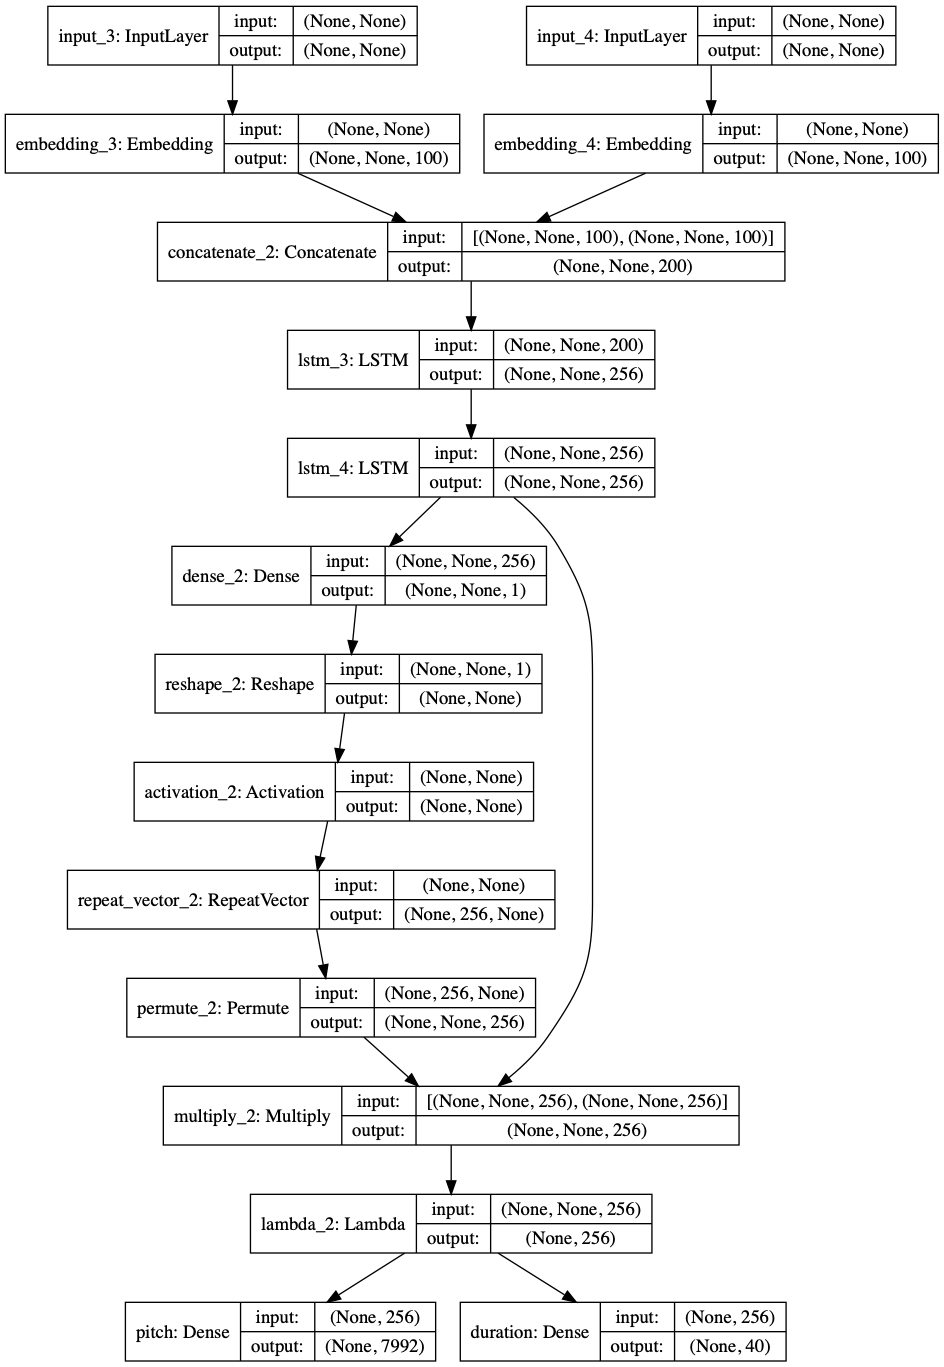

In [26]:
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

## Train the neural network

In [27]:
weights_folder = os.path.join(run_folder, 'weights')
# model.load_weights(os.path.join(weights_folder, "weights.h5"))

In [ ]:
weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
model.fit(network_input, network_output
          , epochs=2000000, batch_size=32
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )



/Users/weiliang/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 13262 samples, validate on 3316 samples
Epoch 1/2000000
13262/13262 [==============================] - 149s 11ms/step - loss: 10.3029 - pitch_loss: 8.7068 - duration_loss: 1.5954 - val_loss: 11.4142 - val_pitch_loss: 9.6516 - val_duration_loss: 1.7711
Epoch 2/2000000
13262/13262 [==============================] - 150s 11ms/step - loss: 9.4850 - pitch_loss: 8.0833 - duration_loss: 1.4020 - val_loss: 11.6335 - val_pitch_loss: 9.9041 - val_duration_loss: 1.7377
Epoch 3/2000000
13262/13262 [==============================] - 144s 11ms/step - loss: 9.2260 - pitch_loss: 7.8669 - duration_loss: 1.3595 - val_loss: 11.7924 - val_pitch_loss: 9.9008 - val_duration_loss: 1.8998
Epoch 4/2000000
13262/13262 [==============================] - 127s 10ms/step - loss: 9.0477 - pitch_loss: 7.7169 - duration_loss: 1.3311 - val_loss: 11.7939 - val_pitch_loss: 10.0284 - val_duration_loss: 1.7742
Epoch 5/2000000
13262/13262 [==============================] - 119s 9ms/step - loss: 8.8820 - pitch_loss: